In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
import polars as pl
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

In [3]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [4]:
dfreco = pd.read_parquet("recommendations.parquet").set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [10]:
df_user_summary = dfreco.groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'count', 'is_recommended':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})
df_user_summary = df_user_summary[(df_user_summary.helpful > 0)|(df_user_summary.funny > 0)]
df_user_summary = df_user_summary[df_user_summary['products'] >= np.percentile(df_user_summary['products'].values, 99)]

In [11]:
iso = IsolationForest(contamination=0.1)
outliers = iso.fit_predict(df_user_summary)
df_user_summary["ISO"] = outliers
df_user_summary['type'] = df_user_summary['ISO'].apply(lambda x: "Outlier" if x == -1 else "Inlier")
df_user_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41754 entries, 1239 to 14305792
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   helpful      41754 non-null  int64 
 1   funny        41754 non-null  int64 
 2   products     41754 non-null  int64 
 3   recommended  41754 non-null  int64 
 4   ISO          41754 non-null  int64 
 5   type         41754 non-null  object
dtypes: int64(5), object(1)
memory usage: 2.2+ MB


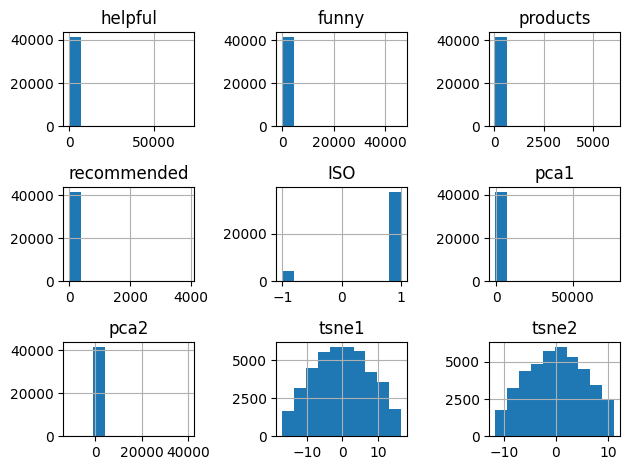

In [14]:
df_user_summary.hist()
plt.tight_layout()
plt.show()

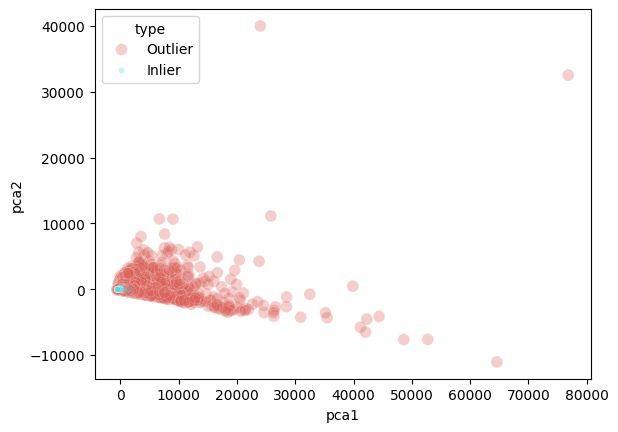

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_user_summary.drop('type', axis=1).values)

df_user_summary['pca1'] = pca_result[:,0]
df_user_summary['pca2'] = pca_result[:,1] 


sp = sns.scatterplot(
    data=df_user_summary, 
    x="pca1", 
    y="pca2", 
    hue="type",
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    alpha=0.3
)

plt.show(sp)

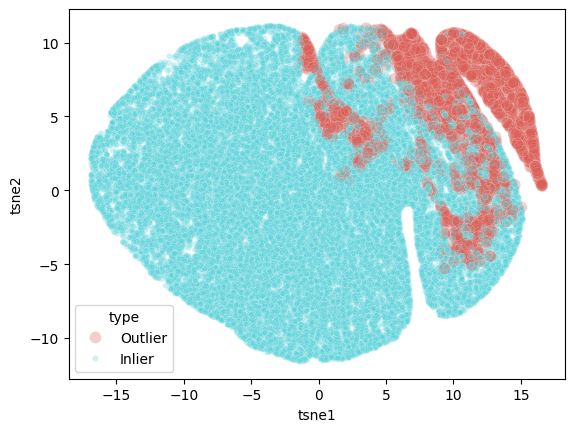

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_user_summary.drop('type', axis=1).values)

df_user_summary['tsne1'] = tsne_results[:,0]
df_user_summary['tsne2'] = tsne_results[:,1] 


sp = sns.scatterplot(
    data=df_user_summary, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    alpha=0.3
)

plt.show(sp)

In [7]:
df_outliers = df_user_summary[df_user_summary["ISO"] == -1]

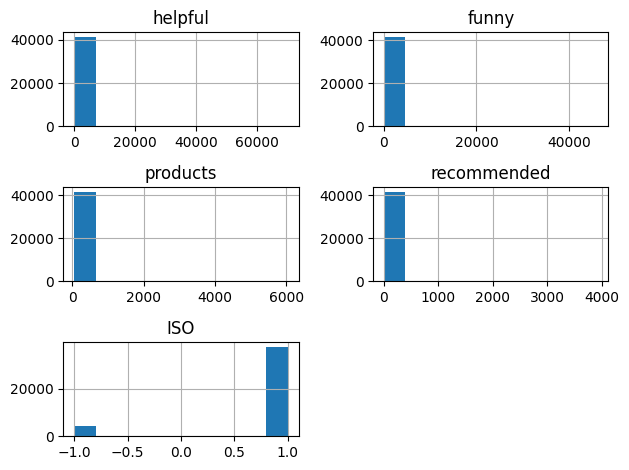

In [2]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

In [3]:
# load our users
dfuser = pd.read_csv("users_mined.csv")
dfuser.set_index('user_id')
dfuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13781059 entries, 0 to 13781058
Data columns (total 8 columns):
 #   Column                 Dtype
---  ------                 -----
 0   user_id                int64
 1   products               int64
 2   reviews                int64
 3   reviewed_on_after      int64
 4   games_recommended      int64
 5   games_not_recommended  int64
 6   agreed_with            int64
 7   disagreed_with         int64
dtypes: int64(8)
memory usage: 841.1 MB


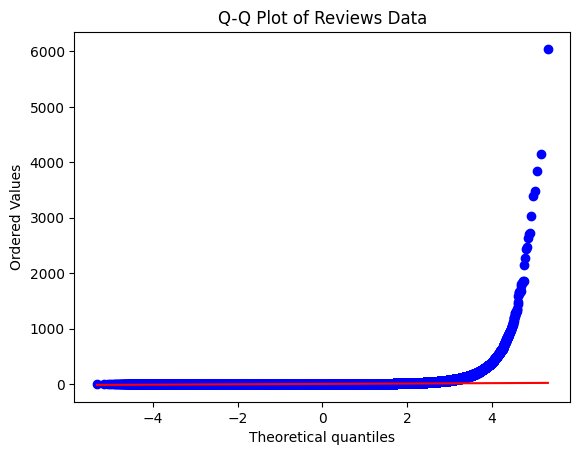

In [4]:
stats.probplot(dfuser.reviews.values, plot=plt)
plt.title('Q-Q Plot of Reviews Data')
plt.show()

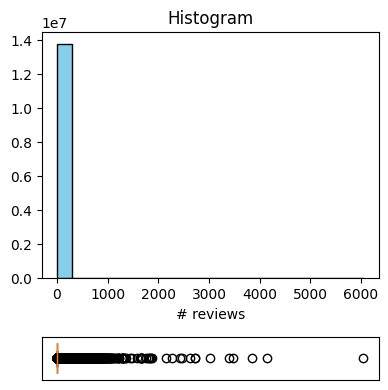

In [5]:
create_box_and_hist(dfuser, 'reviews')

In [6]:
print(f"Reviews Mean: {dfuser.reviews.mean()}")
print(f"Reviews Median: {dfuser.reviews.median()}")
print(f"Reviews Q1: {np.percentile(dfuser.reviews.values, 25)}")
print(f"Reviews Q3: {np.percentile(dfuser.reviews.values, 75)}")
print(f"Reviews 95th Percentile: {np.percentile(dfuser.reviews.values, 95)}")
print(f"Reviews 99th Percentile: {np.percentile(dfuser.reviews.values, 99)}")

Reviews Mean: 2.98633029580673
Reviews Median: 1.0
Reviews Q1: 1.0
Reviews Q3: 3.0
Reviews 95th Percentile: 9.0
Reviews 99th Percentile: 25.0


In [45]:
print(f"Count After 95th Percentile: {len(dfuser[dfuser.reviews >= np.percentile(dfuser.reviews.values, 95)])}")
print(f"Count After 99th Percentile: {len(dfuser[dfuser.reviews >= np.percentile(dfuser.reviews.values, 99)])}")
print(f"Count After 99.9th Percentile: {len(dfuser[dfuser.reviews >= np.percentile(dfuser.reviews.values, 99.9)])}")

Count After 95th Percentile: 802862
Count After 99th Percentile: 143021
Count After 99.9th Percentile: 14031


In [46]:
df_high_reviews = dfuser[dfuser.reviews >= np.percentile(dfuser.reviews.values, 99.9)]

In [47]:
print(f"Reviews Mean: {df_high_reviews.reviews.mean()}")
print(f"Reviews Median: {df_high_reviews.reviews.median()}")
print(f"Reviews Q1: {np.percentile(df_high_reviews.reviews.values, 25)}")
print(f"Reviews Q3: {np.percentile(df_high_reviews.reviews.values, 75)}")
print(f"Reviews 95th Percentile: {np.percentile(df_high_reviews.reviews.values, 95)}")
print(f"Reviews 99th Percentile: {np.percentile(df_high_reviews.reviews.values, 99)}")

Reviews Mean: 145.1338464827881
Reviews Median: 108.0
Reviews Q1: 90.0
Reviews Q3: 148.0
Reviews 95th Percentile: 314.0
Reviews 99th Percentile: 642.1000000000022


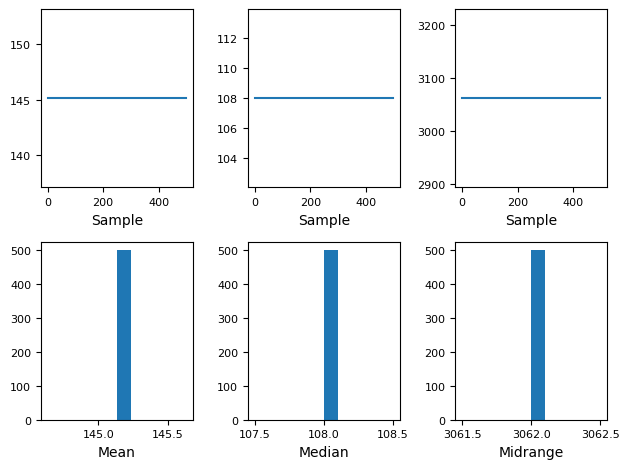

In [51]:
# plot users bootstrap 
pd.plotting.bootstrap_plot(df_high_reviews.drop('products', axis=1).reviews, size=len(df_high_reviews))
plt.show()

In [ ]:
#mean_stats = boot(df_high_reviews, 'reviews', np.median, 'median')
#std_stats = boot(df_high_reviews, 'reviews', np.std, 'standard deviation')

In [ ]:
#[mean_stats.confidence_interval.low, mean_stats.bootstrap_distribution.mean(), mean_stats.confidence_interval.high]

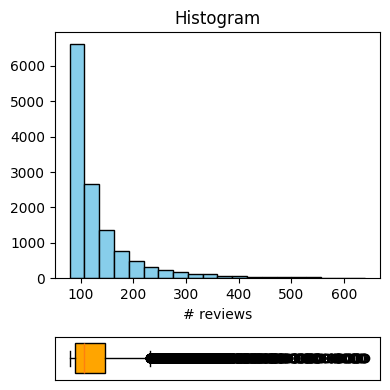

In [52]:
high = np.percentile(df_high_reviews.reviews.values, 99)
low = np.percentile(df_high_reviews.reviews.values, 1)

df_users_clean = df_high_reviews[(df_high_reviews.reviews <= high)&(df_high_reviews.reviews >= low)]
df_users_clean = df_users_clean[(df_users_clean["agreed_with"] > df_users_clean["disagreed_with"])]
create_box_and_hist(df_users_clean, 'reviews')



In [53]:

df_users_clean.corr().style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,user_id,products,reviews,reviewed_on_after,games_recommended,games_not_recommended,agreed_with,disagreed_with
user_id,1.00,0.04,0.03,-0.01,-0.01,-0.00,-0.01,-0.01
products,0.04,1.00,0.20,-0.05,-0.04,-0.06,-0.04,-0.06
reviews,0.03,0.20,1.00,0.28,0.28,0.13,0.28,0.20
reviewed_on_after,-0.01,-0.05,0.28,1.00,0.96,0.58,0.97,0.80
games_recommended,-0.01,-0.04,0.28,0.96,1.00,0.33,1.00,0.60
games_not_recommended,-0.00,-0.06,0.13,0.58,0.33,1.00,0.39,0.94
agreed_with,-0.01,-0.04,0.28,0.97,1.00,0.39,1.00,0.64
disagreed_with,-0.01,-0.06,0.20,0.80,0.60,0.94,0.64,1.00


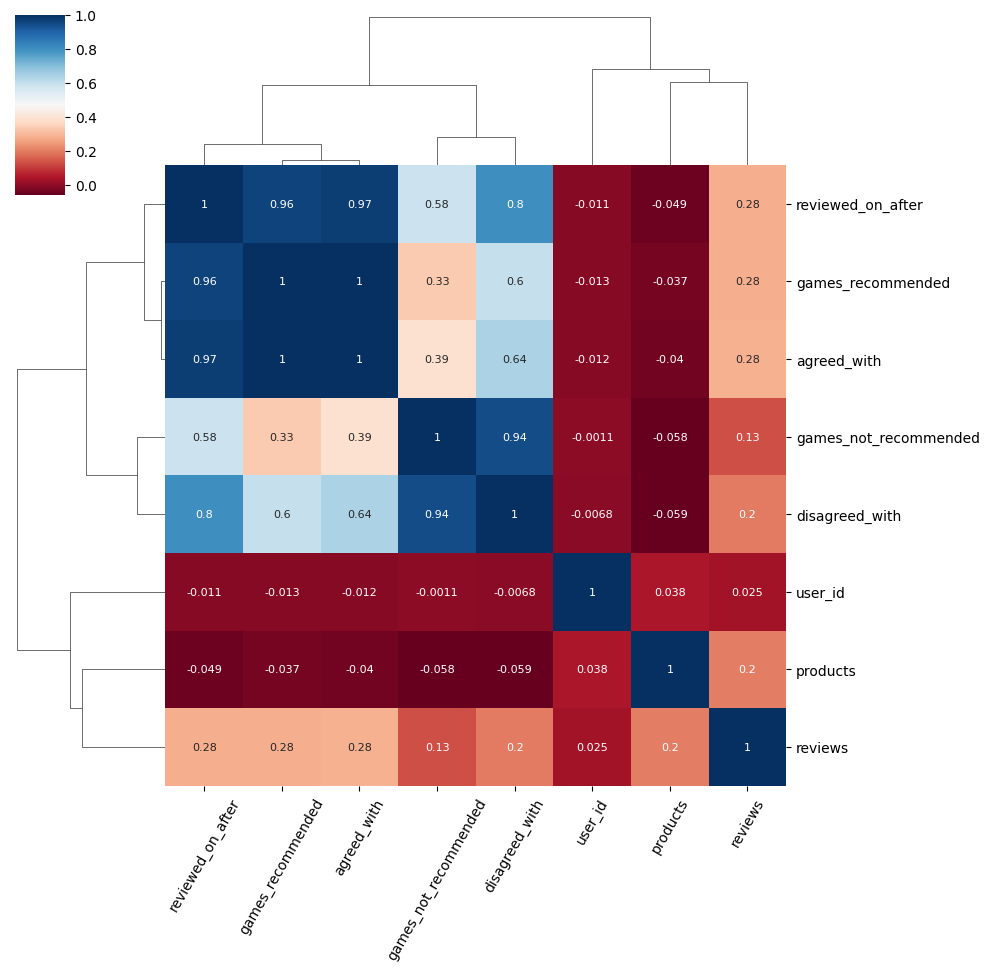

In [54]:
g = sns.clustermap(df_users_clean.corr(), 
                   method = 'complete', 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

In [55]:

df_users_clean = df_users_clean[['user_id', 'products', 'reviews', 'games_recommended', 'agreed_with']]
iso = IsolationForest(contamination=0.1)
outliers = iso.fit_predict(df_users_clean[['user_id', 'products', 'reviews', 'games_recommended', 'agreed_with']])
df_users_clean["ISO"] = outliers

In [56]:
df_outliers = df_users_clean[df_users_clean["ISO"] == -1]

In [57]:
df_outliers

,user_id,products,reviews,games_recommended,agreed_with,ISO
124400,4860602,4058,126,2663214,2490535,-1
125613,1240206,1891,399,1627602,1516875,-1
125945,14033198,150,104,2811132,2541465,-1
126700,6860337,540,281,4276084,3827455,-1
127971,11987647,1724,147,3149780,2918653,-1
...,...,...,...,...,...,...
13357378,11980793,812,129,4101370,3666499,-1
13358311,14027255,2819,189,2263829,2257496,-1
13359249,8604997,950,372,5571197,5299301,-1
13582771,5787568,663,173,3990495,3540916,-1
